<a href="https://colab.research.google.com/github/ashirwadsangwan/Tabular-Data-Projects/blob/master/ashrae_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashirwadsangwan","key":"a562fd00dd6ab5f6b556d2aeeab492e1"}'}

In [6]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Nov 13 08:49 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c ashrae-energy-prediction -p ~/.kaggle --force

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 18.0MB/s]
 81% 97.0M/120M [00:03<00:01, 18.7MB/s]
100% 120M/120M [00:03<00:00, 32.4MB/s] 
 97% 161M/167M [00:05<00:00, 22.2MB/s]
100% 167M/167M [00:05<00:00, 32.8MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 85.3MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.8MB/s]
 83% 73.0M/88.4M [00:02<00:00, 29.2MB/s]
100% 88.4M/88.4M [00:02<00:00, 37.5MB/s]


In [0]:
import gc
import random
import math

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('~/.kaggle/competitions/ashrae-energy-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from warnings import filterwarnings as fw
fw("ignore")


path_data = "~/.kaggle/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

In [11]:
!unzip ~/.kaggle/weather_test.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/weather_train.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/test.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/train.csv.zip -d ~/.kaggle
!unzip ~/.kaggle/sample_submission.csv.zip -d ~/.kaggle

Archive:  /root/.kaggle/weather_test.csv.zip
  inflating: /root/.kaggle/weather_test.csv  
Archive:  /root/.kaggle/weather_train.csv.zip
  inflating: /root/.kaggle/weather_train.csv  
Archive:  /root/.kaggle/test.csv.zip
  inflating: /root/.kaggle/test.csv  
Archive:  /root/.kaggle/train.csv.zip
  inflating: /root/.kaggle/train.csv  
Archive:  /root/.kaggle/sample_submission.csv.zip
  inflating: /root/.kaggle/sample_submission.csv  


In [12]:
!ls ~/.kaggle

building_metadata.csv	   test.csv	  weather_test.csv
kaggle.json		   test.csv.zip   weather_test.csv.zip
sample_submission.csv	   train.csv	  weather_train.csv
sample_submission.csv.zip  train.csv.zip  weather_train.csv.zip


In [0]:
!rm ~/.kaggle/sample_submission.csv.zip
!rm ~/.kaggle/train.csv.zip
!rm ~/.kaggle/weather_train.csv.zip
!rm ~/.kaggle/test.csv.zip
!rm ~/.kaggle/weather_test.csv.zip

In [14]:
gc.collect()

8

In [15]:
!ls ~/.kaggle/

building_metadata.csv  test.csv		 weather_train.csv
kaggle.json	       train.csv
sample_submission.csv  weather_test.csv


In [0]:
train_df = pd.read_csv(path_train)

building = pd.read_csv(path_building)
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

weather_train = pd.read_csv(path_weather_train)

In [0]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [18]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building = reduce_mem_usage(building, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)
gc.collect()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 74.9%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


0

In [0]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    day_before_holiday = ["2016-01-17", "2016-02-14", "2016-05-29", "2016-07-03",
                "2016-09-04", "2016-10-09", "2016-11-10", "2016-11-23", "2016-12-25",
                "2016-12-31", "2017-01-15", "2017-02-19", "2017-05-28", "2017-07-03",
                "2017-09-03", "2017-10-08", "2017-11-09", "2017-11-22", "2017-12-24",
                "2017-12-31", "2018-01-14", "2018-02-18", "2018-05-27", "2018-07-03",
                "2018-09-02", "2018-10-07", "2018-11-11", "2018-11-21", "2018-12-24",
                "2018-12-31"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    X["is_day_before_holiday"] = (X.timestamp.dt.date.astype("str").isin(day_before_holiday)).astype(int)

    X['month_datetime'] = X['timestamp'].dt.month.astype(np.int8)
    X['weekofyear_datetime'] = X['timestamp'].dt.weekofyear.astype(np.int8)
    X['dayofyear_datetime'] = X['timestamp'].dt.dayofyear.astype(np.int16)

    X['hour_datetime'] = X['timestamp'].dt.hour.astype(np.int8)  
    X['day_week'] = X['timestamp'].dt.dayofweek.astype(np.int8)
    X['day_month_datetime'] = X['timestamp'].dt.day.astype(np.int8)
    X['week_month_datetime'] = X['timestamp'].dt.day/7
    X['week_month_datetime'] = X['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

    X['year_built'] = X['year_built']-1900
    X['square_feet'] = np.log(X['square_feet'])
    
    
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [20]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [21]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03
std,4.269133e+02,9.309921e-01,1.532159e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


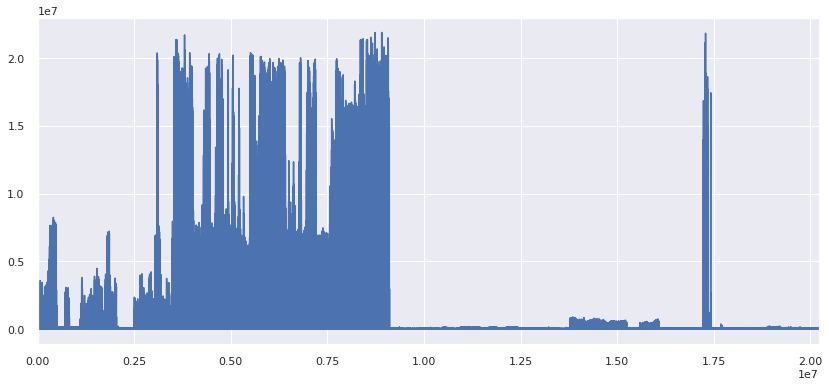

In [22]:
train_df.meter_reading.plot(kind='line', figsize=(14,6));

In [23]:
train_df.nunique()

building_id         1449
meter                  4
timestamp           8784
meter_reading    1688175
dtype: int64

In [24]:
train_df.meter.unique()

array([0, 3, 1, 2])

In [26]:
train_df.meter.value_counts()

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

In [31]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [36]:
weather_train.groupby(['site_id', 'timestamp']).agg(['mean', 'median'])

air_temperature             ... wind_speed          
                                       mean     median  ...       mean    median
site_id timestamp                                       ...                     
0       2016-01-01 00:00:00       25.000000  25.000000  ...   0.000000  0.000000
        2016-01-01 01:00:00       24.406250  24.406250  ...   1.500000  1.500000
        2016-01-01 02:00:00       22.796875  22.796875  ...   0.000000  0.000000
        2016-01-01 03:00:00       21.093750  21.093750  ...   0.000000  0.000000
        2016-01-01 04:00:00       20.000000  20.000000  ...   2.599609  2.599609
...                                     ...        ...  ...        ...       ...
15      2016-12-31 19:00:00        3.000000   3.000000  ...   5.699219  5.699219
        2016-12-31 20:00:00        2.800781   2.800781  ...   7.699219  7.699219
        2016-12-31 21:00:00        2.800781   2.800781  ...   5.101562  5.101562
        2016-12-31 22:00:00        2.199219   2.199219  ...   4.601562  4.601562
        2016-12-31 23:00:00        1.700195   1.700195  ...   8.796875  8.796875

[140544 rows x 14 columns]

In [37]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [38]:
building.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [1]:
building.shape


NameError: ignored

In [42]:
train = train_df.merge(building, on='building_id', how='left')
del train_df
gc.collect()

407

In [0]:
train_final = train.merge(weather_train, on='site_id', how='left')
del train
gc.collect()